In [2]:
%env NUMBA_NUM_THREADS=2
%env OMP_NUM_THREADS=2

env: NUMBA_NUM_THREADS=2
env: OMP_NUM_THREADS=2


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys,os
sys.path.insert(0,'../')

In [5]:
from ml_tools.descriptors import RawSoapInternal
from ml_tools.models import FullCovarianceTrainer,SoRTrainer
from ml_tools.utils import get_mae,get_rmse,get_sup,get_spearman,get_score,load_pck,dump_obj,load_obj
from ml_tools.split import KFold,LCSplit,ShuffleSplit
from ml_tools.model_selection import KRRFastCVScorer,CrossValidationScorer,GridSearch,LearningCurve
from ml_tools.compressor import FPSFilter
from ml_tools.kernels import make_kernel

In [6]:
import numpy as np
from ase.io import read,write
from ase.visualize import view

In [11]:
frames = read('/local/scratch/density_paper/xyz/dft-smiles_30000.xyz',index=':')
pp = np.load('/local/scratch/density_paper/xyz/dft-smiles_eV_30000.dHf_peratom.npy')
N = 1000
np.random.seed(10)
ids = np.arange(len(frames))
np.random.shuffle(ids)
subset = []
target_property = []

for it,ii in enumerate(ids):
    if 9 in frames[ii].get_atomic_numbers():
        continue
    if it >= N: 
        break 
        
    subset.append(frames[ii])
    subset[-1].info['dft_formation_energy_per_atom_in_eV'] = pp[ii]
    subset[-1].set_pbc(False)
    subset[-1].set_cell(np.eye(3)*14)
    pos = frames[ii].get_positions()
    CM = np.mean(pos,axis=0)
    subset[-1].set_positions(pos - CM + 7*np.ones(3))
    target_property.append(pp[ii])
    
target_property = np.array(target_property)
frames = subset

In [12]:
# load the structures
# frames = read('data/dft-smiles_500.xyz',':')
N = 800
global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# split the structures in 2 sets
frames_train = frames[:N]
frames_test = frames[N:]

# set up the soap parameters
soap_params = dict(rc=3.5, nmax=6, lmax=6, awidth=0.4,
                   global_species=global_species,nocenters=[])

representation = RawSoapInternal(**soap_params)

# the reference energies are already formation energies per atom.
self_contribution = {1:0.,6:0.,7:0.,8:0.,9:0.}

In [13]:
def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
    y = np.array(prop)
    return y

# Build a kernel Matrix

In [ ]:
# set up the kernel parameters
kernel = make_kernel(name='power_sum',zeta=2)

In [ ]:
# compute the soap vectors
X_train = representation.transform(frames_train)

# compute the soap vectors
X_test = representation.transform(frames_test)

In [ ]:
# compute the square kernel matrix
Kmat = kernel.transform(X_train)

In [ ]:
# compute a rectangular kernel matrix
Kmat_rect = kernel.transform(X_test,X_train)

# Train a regression model

In [31]:
y_train = extract_energy(frames_train)

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power_sum',
                                self_contribution=self_contribution,feature_transformations=representation)

In [32]:
X_train = representation.transform(frames_train)

In [33]:
y_test = extract_energy(frames_test)
X_test = representation.transform(frames_test)

In [34]:
trainer.precompute(y_train, X_train)

In [35]:
model = trainer.fit(lambdas=[5e-4])

In [36]:
y_pred = model.predict(X_test)
get_score(y_pred,y_test)

{'CORR': 0.9955365604033205,
 'MAE': 0.011802525672232672,
 'R2': 0.9904694644661962,
 'RMSE': 0.016713025908117286,
 'SUP': 0.0690777866144856}

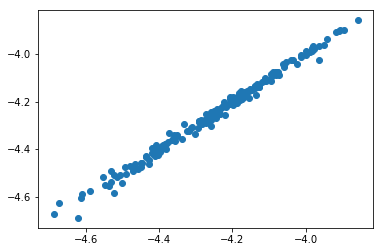

In [37]:
plt.plot(y_pred,y_test,'o')

# FPS selection of the samples

In [ ]:
# set up the kernel parameters
kernel = make_kernel(name='power_sum',zeta = 2)

In [ ]:
# compute the soap vectors
rawsoaps = representation.transform(frames)

In [ ]:
# run the fps selection on the set and plot the minmax distance
Nselect = 250
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [ ]:
# select the appropriate number of samples to select
compressor.Nselect = 250
# and compress
rawsoaps_compressed = compressor.transform(rawsoaps)

# get a cross validation score

In [ ]:
zeta = 2
sigma = 5e-4

representation = RawSoapInternal(**soap_params)
trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power_sum',
                                self_contribution=self_contribution,feature_transformations=representation)
cv = KFold(n_splits=5,random_state=10,shuffle=True)
scorer = KRRFastCVScorer([sigma],trainer,cv)

In [ ]:
# compute the soap vectors
rawsoaps = representation.transform(frames)
y = extract_energy(frames)

In [ ]:
# fit the model
scorer.fit(rawsoaps,y)

print scorer.get_summary(txt=True)

# LC

In [ ]:
zeta = 2
sigma = 5e-4

trainer = FullCovarianceTrainer(zeta=2, model_name='krr', kernel_name='power_sum', 
                                self_contribution=self_contribution,feature_transformations=representation)

In [ ]:
# compute the soap vectors
rawsoaps = representation.transform(frames)
y = extract_energy(frames)

In [ ]:
n_repeats=[10,5,5,3]
train_sizes=[50,100,200,300]
test_size=100
seed=10
model_params = {'lambdas':[sigma]}
lc = LearningCurve(trainer,model_params,n_repeats,train_sizes,test_size,seed)
lc.fit(rawsoaps,y)

In [ ]:
ax = lc.plot('RMSE')
ax.set_ylabel('RMSE [eV/atom]')
ax.set_xlabel('Number of Training Molecule')
ax.set_title('Learning Curve')
